# Assignment 2
# Part 1

In [53]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Torchvision (datasets, transforms, models)
import torchvision
import torchvision.transforms as transforms

# Data processing and splitting
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import copy

import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader






## Preprocessing and loading Data

In [6]:
# Load MNIST dataset (train + test) from torchvision
transform = torchvision.transforms.ToTensor()

# Load training portion of MNIST (60,000 images)
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

# Load test portion of MNIST (10,000 images)
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Combine data from both train and test sets
full_data = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# Extract all images and labels
X = []
y = []

for img, label in full_data:
    X.append(img.numpy())      # Convert tensor to numpy
    y.append(label)

X = np.array(X)  # Shape: (70000, 1, 28, 28)
y = np.array(y)  # Shape: (70000,)

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    train_size=0.6,
    stratify=y,           # Ensures class balance across splits
    random_state=42       # For reproducibility
)

# Second split: 50% val, 50% test of temp → each 20% of total
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,         # Split 40% → 20% and 20%
    stratify=y_temp,
    random_state=42
)

# Reshape: flatten 28x28 images to 784-dimensional vectors
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (42000, 784)
X_val_flat = X_val.reshape(X_val.shape[0], -1)        # (14000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)     # (14000, 784)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset for each split
train_dataset_flat = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_flat = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_flat = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders with batch size 64 (common default)
batch_size = 64

train_loader = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_flat, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_flat, batch_size=batch_size, shuffle=False)

# Verify shapes
print("Training data shape:", X_train_tensor.shape)   # Should be (42000, 784)
print("Validation data shape:", X_val_tensor.shape)   # (14000, 784)
print("Test data shape:", X_test_tensor.shape)        # (14000, 784)
print("Train loader batch count:", len(train_loader)) # ~657 batches (42000/64)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.79MB/s]


Training data shape: torch.Size([42000, 784])
Validation data shape: torch.Size([14000, 784])
Test data shape: torch.Size([14000, 784])
Train loader batch count: 657


## Filtering Data

In [7]:
# Filter training data: keep only labels 0 and 1
train_mask = (y_train_tensor == 0) | (y_train_tensor == 1)
X_train_bin = X_train_tensor[train_mask]
y_train_bin = y_train_tensor[train_mask]

# Filter validation data
val_mask = (y_val_tensor == 0) | (y_val_tensor == 1)
X_val_bin = X_val_tensor[val_mask]
y_val_bin = y_val_tensor[val_mask]

# Filter test data
test_mask = (y_test_tensor == 0) | (y_test_tensor == 1)
X_test_bin = X_test_tensor[test_mask]
y_test_bin = y_test_tensor[test_mask]

print(f"Training set size (0 vs 1): {X_train_bin.shape[0]}")
print(f"Validation set size: {X_val_bin.shape[0]}")
print(f"Test set size: {X_test_bin.shape[0]}")

Training set size (0 vs 1): 8868
Validation set size: 2957
Test set size: 2955


## Binary classification

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Input dimension
input_dim = X_train_bin.shape[1]  # 784

# Initialize weights and bias
W = torch.randn(input_dim, 1, requires_grad=False) * 0.01  # Shape: (784, 1)
b = torch.zeros(1, requires_grad=False)                     # Scalar bias

In [9]:
def sigmoid(z):
    # Clip z to prevent overflow
    z = torch.clamp(z, -500, 500)
    return 1 / (1 + torch.exp(-z))

def binary_cross_entropy(y_true, y_pred):
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    
# Hyperparameters
learning_rate = 0.01
num_epochs = 500
print_every = 50

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

## Training

In [10]:
for epoch in range(num_epochs):
    # -------------------
    # Forward Pass (Training)
    # -------------------
    z = X_train_bin @ W + b                # Linear output: (N, 1)
    y_pred_train = sigmoid(z)              # Sigmoid output: (N, 1)
    y_pred_train_label = (y_pred_train >= 0.5).float()  # Binary predictions

    # Compute loss
    loss = binary_cross_entropy(y_train_bin.float().view(-1, 1), y_pred_train)

    # Compute accuracy
    acc = accuracy_score(y_train_bin.numpy(), y_pred_train_label.numpy())

    # -------------------
    # Validation Pass
    # -------------------
    z_val = X_val_bin @ W + b
    y_pred_val = sigmoid(z_val)
    y_pred_val_label = (y_pred_val >= 0.5).float()

    val_loss = binary_cross_entropy(y_val_bin.float().view(-1, 1), y_pred_val)
    val_acc = accuracy_score(y_val_bin.numpy(), y_pred_val_label.numpy())

    # Store metrics
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)

    # -------------------
    # Manual Gradient Descent
    # -------------------
    # Derivative of BCE w.r.t y_pred: (y_pred - y_true) / (y_pred * (1 - y_pred))
    # But easier: dL/dz = y_pred - y_true  (known gradient identity)

    m = X_train_bin.shape[0]  # batch size
    dz = (y_pred_train - y_train_bin.float().view(-1, 1)) / m  # (N, 1)

    # Gradients w.r.t W and b
    dW = X_train_bin.t() @ dz  # (784, 1)
    db = torch.sum(dz)         # scalar

    # Update parameters (gradient descent)
    W = W - learning_rate * dW
    b = b - learning_rate * db

    # Print every `print_every` epochs
    if (epoch+1) % print_every == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch [50/500], Train Loss: 0.2033, Val Loss: 0.2025, Train Acc: 0.9968, Val Acc: 0.9976
Epoch [100/500], Train Loss: 0.1201, Val Loss: 0.1188, Train Acc: 0.9966, Val Acc: 0.9980
Epoch [150/500], Train Loss: 0.0874, Val Loss: 0.0861, Train Acc: 0.9968, Val Acc: 0.9980
Epoch [200/500], Train Loss: 0.0699, Val Loss: 0.0685, Train Acc: 0.9968, Val Acc: 0.9980
Epoch [250/500], Train Loss: 0.0589, Val Loss: 0.0575, Train Acc: 0.9968, Val Acc: 0.9980
Epoch [300/500], Train Loss: 0.0513, Val Loss: 0.0500, Train Acc: 0.9968, Val Acc: 0.9980
Epoch [350/500], Train Loss: 0.0457, Val Loss: 0.0444, Train Acc: 0.9971, Val Acc: 0.9980
Epoch [400/500], Train Loss: 0.0414, Val Loss: 0.0402, Train Acc: 0.9971, Val Acc: 0.9980
Epoch [450/500], Train Loss: 0.0380, Val Loss: 0.0368, Train Acc: 0.9971, Val Acc: 0.9980
Epoch [500/500], Train Loss: 0.0353, Val Loss: 0.0341, Train Acc: 0.9971, Val Acc: 0.9980


## Plot Learning Curve

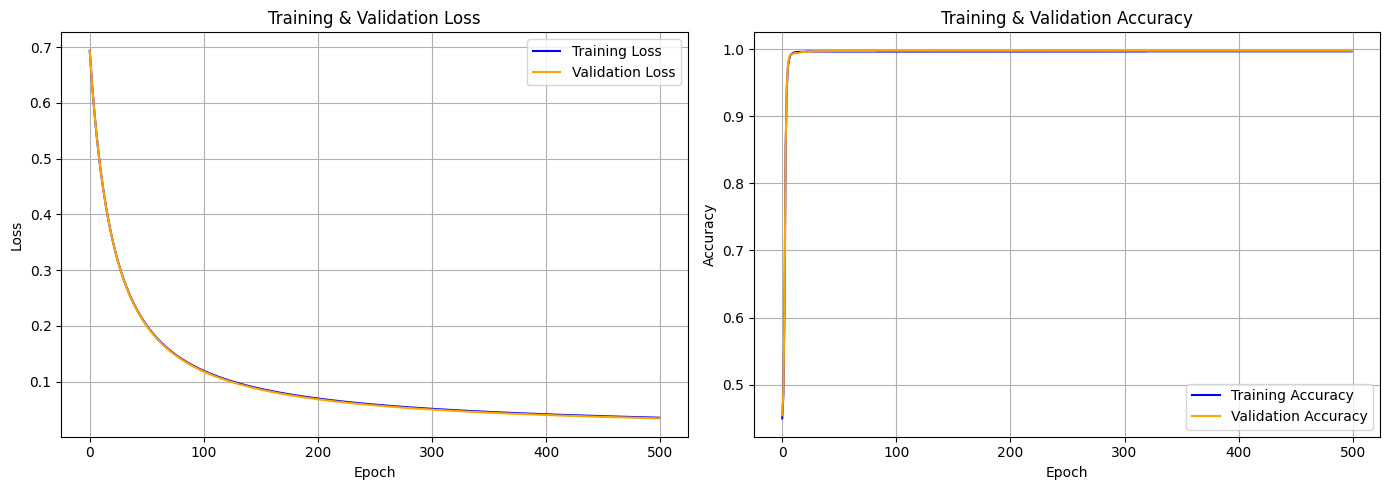

In [11]:
plt.figure(figsize=(14, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Test Model

Final Test Accuracy (0 vs 1): 0.9970


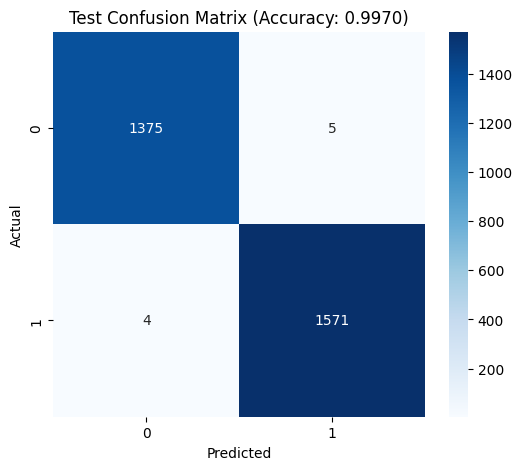

In [12]:
# Final test forward pass
z_test = X_test_bin @ W + b
y_pred_test = sigmoid(z_test)
y_pred_test_label = (y_pred_test >= 0.5).float()

# Compute test accuracy
test_acc = accuracy_score(y_test_bin.numpy(), y_pred_test_label.numpy())
print(f"Final Test Accuracy (0 vs 1): {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_bin.numpy(), y_pred_test_label.numpy())
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title(f'Test Confusion Matrix (Accuracy: {test_acc:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Implement Softmax

In [24]:
# Set seed for reproducibility
torch.manual_seed(42)

# Dimensions
input_dim = 784   # flattened image
num_classes = 10  # digits 0-9

# Initialize weights and bias
W = torch.randn(input_dim, num_classes, requires_grad=False) * 0.01  # (784, 10)
b = torch.zeros(num_classes, requires_grad=False)                     # (10,)

def softmax(z):
    # Subtract max for numerical stability
    z = z - z.max(dim=1, keepdim=True)[0]
    exp_z = torch.exp(z)
    return exp_z / exp_z.sum(dim=1, keepdim=True)

def cross_entropy_loss(y_true, y_pred):
    """
    y_true: (N,) long tensor of class indices
    y_pred: (N, 10) probability distribution (after softmax)
    """
    # One-hot encode y_true
    y_true_onehot = F.one_hot(y_true, num_classes=10).float()  # (N, 10)
    
    # Clip predictions to avoid log(0)
    y_pred_clipped = torch.clamp(y_pred, 1e-15, 1 - 1e-15)
    
    # Cross-entropy: -sum(y_true * log(y_pred))
    loss = - (y_true_onehot * torch.log(y_pred_clipped)).sum(dim=1).mean()
    return loss

## Train model

In [41]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import numpy as np

def train_softmax_model(X_train, y_train, X_val, y_val,
                        num_classes=10,
                        learning_rate=0.01,
                        num_epochs=1000,
                        print_every=50):
    """
    Train a linear softmax classifier with manual gradient descent.

    Args:
        X_train, X_val: torch.Tensor, shape (N, D)
        y_train, y_val: torch.Tensor, shape (N,)
        num_classes: int, number of classes
        learning_rate: float
        num_epochs: int
        print_every: int, frequency to print progress

    Returns:
        W, b: trained weights and biases
        history: dict with train/val losses and accuracies
    """

    # Initialize parameters
    D = X_train.shape[1]
    W = torch.zeros(D, num_classes, dtype=torch.float32)
    b = torch.zeros(num_classes, dtype=torch.float32)

    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # -------------------
        # Forward Pass (Training)
        # -------------------
        z = X_train @ W + b
        y_pred_train = F.softmax(z, dim=1)
        y_pred_train_label = torch.argmax(y_pred_train, dim=1)

        # Compute loss and accuracy
        loss = F.cross_entropy(z, y_train)  # Use logits directly for numerical stability
        acc = accuracy_score(y_train.numpy(), y_pred_train_label.numpy())

        # -------------------
        # Validation Pass
        # -------------------
        z_val = X_val @ W + b
        y_pred_val = F.softmax(z_val, dim=1)
        y_pred_val_label = torch.argmax(y_pred_val, dim=1)

        val_loss = F.cross_entropy(z_val, y_val)
        val_acc = accuracy_score(y_val.numpy(), y_pred_val_label.numpy())

        # Store metrics
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(acc)
        val_accuracies.append(val_acc)

        # -------------------
        # Manual Gradient Descent
        # -------------------
        m = X_train.shape[0]
        y_true_onehot = F.one_hot(y_train, num_classes=num_classes).float()

        dz = (y_pred_train - y_true_onehot) / m
        dW = X_train.t() @ dz
        db = dz.sum(dim=0)

        W -= learning_rate * dW
        b -= learning_rate * db

        # Print progress
        if (epoch + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {acc:.4f}, Val Acc: {val_acc:.4f}")

    history = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accuracies,
        "val_acc": val_accuracies
    }

    return W, b, history


In [42]:
W_trained, b_trained, history = train_softmax_model(
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    num_classes=10,
    learning_rate=0.01,
    num_epochs=1500,
    print_every=50
)


Epoch [50/1500], Train Loss: 1.8620, Val Loss: 1.8637, Train Acc: 0.7519, Val Acc: 0.7525
Epoch [100/1500], Train Loss: 1.5539, Val Loss: 1.5564, Train Acc: 0.7795, Val Acc: 0.7817
Epoch [150/1500], Train Loss: 1.3409, Val Loss: 1.3440, Train Acc: 0.7975, Val Acc: 0.7990
Epoch [200/1500], Train Loss: 1.1899, Val Loss: 1.1933, Train Acc: 0.8093, Val Acc: 0.8104
Epoch [250/1500], Train Loss: 1.0789, Val Loss: 1.0824, Train Acc: 0.8181, Val Acc: 0.8186
Epoch [300/1500], Train Loss: 0.9945, Val Loss: 0.9981, Train Acc: 0.8251, Val Acc: 0.8264
Epoch [350/1500], Train Loss: 0.9283, Val Loss: 0.9320, Train Acc: 0.8311, Val Acc: 0.8312
Epoch [400/1500], Train Loss: 0.8750, Val Loss: 0.8788, Train Acc: 0.8355, Val Acc: 0.8349
Epoch [450/1500], Train Loss: 0.8312, Val Loss: 0.8351, Train Acc: 0.8390, Val Acc: 0.8386
Epoch [500/1500], Train Loss: 0.7945, Val Loss: 0.7984, Train Acc: 0.8426, Val Acc: 0.8418
Epoch [550/1500], Train Loss: 0.7633, Val Loss: 0.7672, Train Acc: 0.8461, Val Acc: 0.8449


## plot learning curve

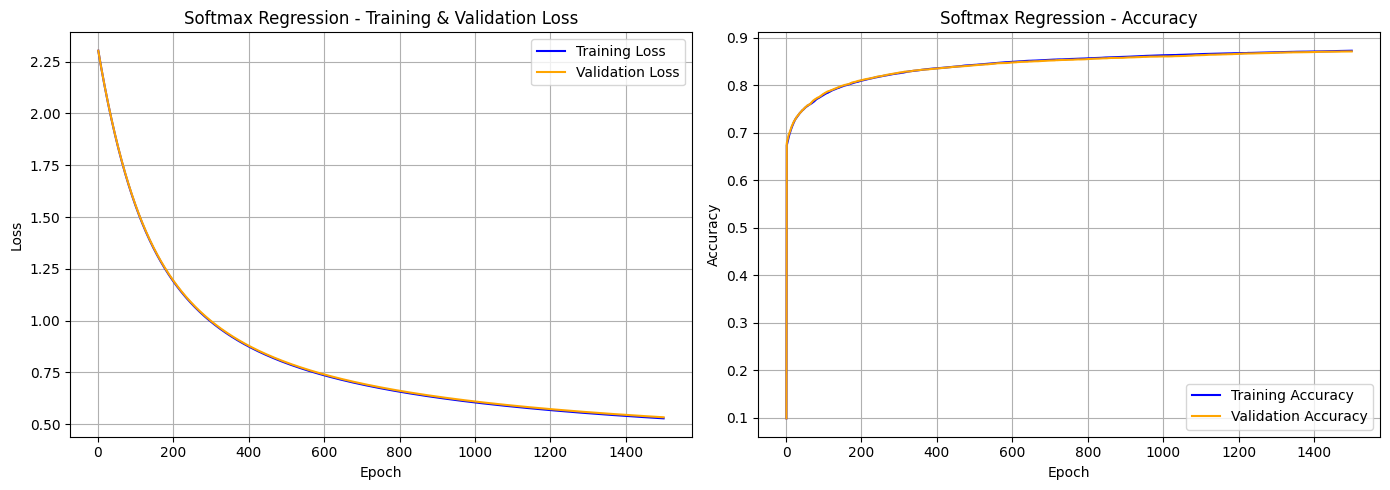

In [28]:
# Suppose history1 = first 500 epochs, history2 = next 1000 epochs
train_losses = history['train_loss']
val_losses = history['val_loss'] 
train_accuracies = history['train_acc'] 
val_accuracies = history['val_acc'] 

# Plotting all 1500 epochs
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(14, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.title('Softmax Regression - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Softmax Regression - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Compare with PyTorch Built-In Model

In [30]:
# Compute loss using PyTorch built-in
z_torch = X_train_tensor @ W_trained + b_trained
loss_torch = F.cross_entropy(z_torch, y_train_tensor)

print(f"Manual Cross-Entropy Loss: {loss:.6f}")
print(f"PyTorch F.cross_entropy:   {loss_torch.item():.6f}")
print(f"Difference: {abs(loss - loss_torch.item()):.8f}")

Manual Cross-Entropy Loss: 0.606077
PyTorch F.cross_entropy:   0.528496
Difference: 0.07758087


# part 2

In [17]:


# Custom Feedforward Neural Network
class FeedforwardNN(nn.Module):
    def __init__(self, input_size=784, hidden1=256, hidden2=128, output_size=10):
        super(FeedforwardNN, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)
        
        # Initialize weights (Xavier initialization)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # Forward pass with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output logits (no softmax here, handled by loss fn)
        return x


# Instantiate model
model = FeedforwardNN(input_size=784, hidden1=256, hidden2=128, output_size=10)
# Check architecture
print(model)

FeedforwardNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [18]:
def train_model(model, 
                train_dataset, val_dataset, test_dataset,
                batch_size=32, lr=0.01, num_epochs=30, patience=3,
                device=None):
    """
    Train a PyTorch model with early stopping.
    
    Args:
        model: PyTorch model to train.
        train_dataset, val_dataset, test_dataset: PyTorch Dataset objects.
        batch_size: int, batch size for DataLoader.
        lr: float, learning rate.
        num_epochs: int, maximum number of epochs.
        patience: int, early stopping patience.
        device: torch.device, device to train on.
    
    Returns:
        model: trained model with best weights.
        history: dictionary containing training/validation losses and accuracies.
    """
    
    # Device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Move model to device
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Tracking
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_acc = [], []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())
            _, predicted = outputs.max(1)
            acc = predicted.eq(targets).sum().item() / targets.size(0)
            running_acc.append(acc)

        train_loss = np.mean(running_loss)
        train_acc = np.mean(running_acc)

        # Validation
        model.eval()
        val_running_loss, val_running_acc = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_running_loss.append(loss.item())
                _, predicted = outputs.max(1)
                acc = predicted.eq(targets).sum().item() / targets.size(0)
                val_running_acc.append(acc)

        val_loss = np.mean(val_running_loss)
        val_acc = np.mean(val_running_acc)

        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Logging
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% "
              f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_model.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    history = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accuracies,
        "val_acc": val_accuracies
    }

    return model, history


In [19]:
trained_model, history = train_model(model, 
                                train_dataset_flat, 
                                     val_dataset_flat, 
                                     test_dataset_flat,
                                    batch_size=64, lr=0.01, num_epochs=50, patience=5)


Using device: cuda
Epoch [1/50] Train Loss: 1.0245, Train Acc: 75.31% | Val Loss: 0.4957, Val Acc: 87.22%
Epoch [2/50] Train Loss: 0.4081, Train Acc: 88.94% | Val Loss: 0.3662, Val Acc: 89.78%
Epoch [3/50] Train Loss: 0.3294, Train Acc: 90.74% | Val Loss: 0.3225, Val Acc: 90.76%
Epoch [4/50] Train Loss: 0.2918, Train Acc: 91.72% | Val Loss: 0.2939, Val Acc: 91.60%
Epoch [5/50] Train Loss: 0.2655, Train Acc: 92.48% | Val Loss: 0.2740, Val Acc: 92.14%
Epoch [6/50] Train Loss: 0.2446, Train Acc: 93.10% | Val Loss: 0.2521, Val Acc: 92.93%
Epoch [7/50] Train Loss: 0.2270, Train Acc: 93.59% | Val Loss: 0.2416, Val Acc: 93.16%
Epoch [8/50] Train Loss: 0.2123, Train Acc: 94.05% | Val Loss: 0.2295, Val Acc: 93.44%
Epoch [9/50] Train Loss: 0.1995, Train Acc: 94.43% | Val Loss: 0.2157, Val Acc: 93.81%
Epoch [10/50] Train Loss: 0.1882, Train Acc: 94.73% | Val Loss: 0.2049, Val Acc: 94.11%
Epoch [11/50] Train Loss: 0.1784, Train Acc: 95.01% | Val Loss: 0.1971, Val Acc: 94.40%
Epoch [12/50] Train Lo

## Visualising the Model

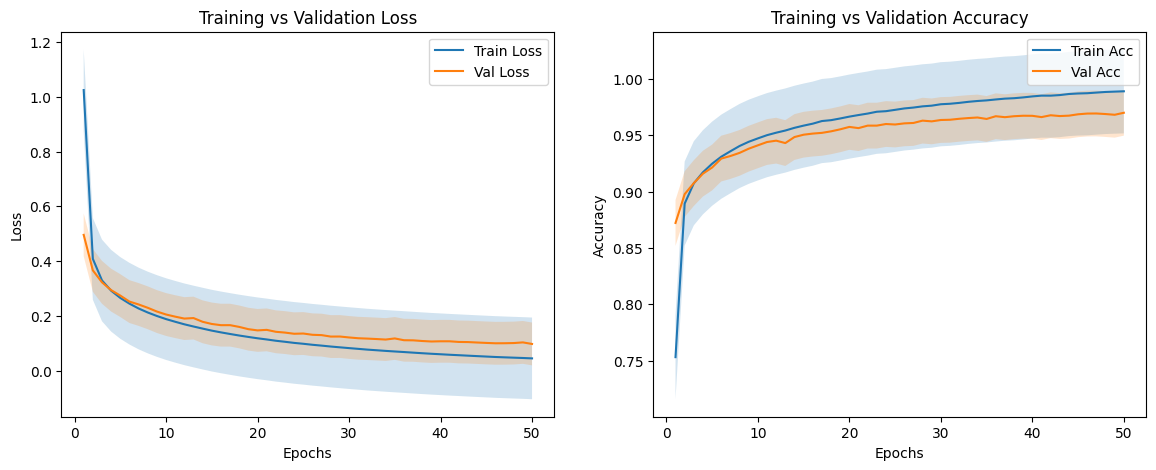

In [21]:
# Use trained_model (already has best weights) and history
train_losses = history['train_loss']
val_losses = history['val_loss']
train_accuracies = history['train_acc']
val_accuracies = history['val_acc']

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(14, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.fill_between(epochs, 
                 np.array(train_losses)-np.std(train_losses),
                 np.array(train_losses)+np.std(train_losses),
                 alpha=0.2)
plt.fill_between(epochs, 
                 np.array(val_losses)-np.std(val_losses),
                 np.array(val_losses)+np.std(val_losses),
                 alpha=0.2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.fill_between(epochs, 
                 np.array(train_accuracies)-np.std(train_accuracies),
                 np.array(train_accuracies)+np.std(train_accuracies),
                 alpha=0.2)
plt.fill_between(epochs, 
                 np.array(val_accuracies)-np.std(val_accuracies),
                 np.array(val_accuracies)+np.std(val_accuracies),
                 alpha=0.2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


## Making seperate  plots to visualize better

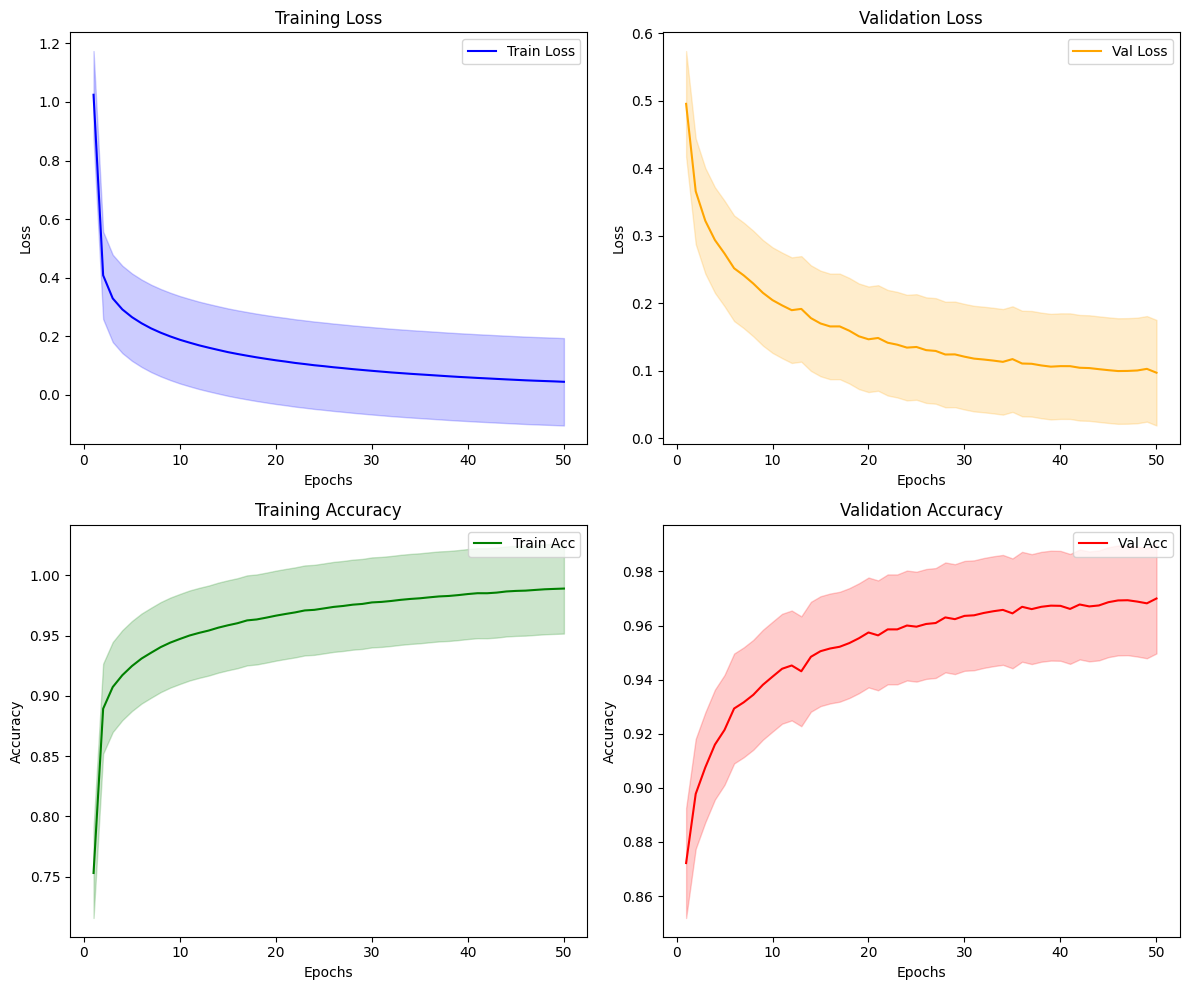

In [22]:

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 10))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, color="blue", label="Train Loss")
plt.fill_between(epochs,
                 np.array(train_losses)-np.std(train_losses),
                 np.array(train_losses)+np.std(train_losses),
                 alpha=0.2, color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, val_losses, color="orange", label="Val Loss")
plt.fill_between(epochs,
                 np.array(val_losses)-np.std(val_losses),
                 np.array(val_losses)+np.std(val_losses),
                 alpha=0.2, color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accuracies, color="green", label="Train Acc")
plt.fill_between(epochs,
                 np.array(train_accuracies)-np.std(train_accuracies),
                 np.array(train_accuracies)+np.std(train_accuracies),
                 alpha=0.2, color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, val_accuracies, color="red", label="Val Acc")
plt.fill_between(epochs,
                 np.array(val_accuracies)-np.std(val_accuracies),
                 np.array(val_accuracies)+np.std(val_accuracies),
                 alpha=0.2, color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# Part c

## Learning rate analysis

### soft max

In [31]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
histories = {}

for lr in learning_rates:
    print(f"\nTraining Softmax Model with learning rate = {lr}")
    W_trained, b_trained, history = train_softmax_model(
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor,
        num_classes=10,
        learning_rate=lr,
        num_epochs=500,
        print_every=100
    )
    histories[lr] = history



Training Softmax Model with learning rate = 0.001
Epoch [100/500], Train Loss: 2.1992, Val Loss: 2.1996, Train Acc: 0.7031, Val Acc: 0.7054
Epoch [200/500], Train Loss: 2.1032, Val Loss: 2.1040, Train Acc: 0.7231, Val Acc: 0.7245
Epoch [300/500], Train Loss: 2.0145, Val Loss: 2.0156, Train Acc: 0.7355, Val Acc: 0.7357
Epoch [400/500], Train Loss: 1.9322, Val Loss: 1.9336, Train Acc: 0.7454, Val Acc: 0.7457
Epoch [500/500], Train Loss: 1.8560, Val Loss: 1.8576, Train Acc: 0.7531, Val Acc: 0.7534

Training Softmax Model with learning rate = 0.01
Epoch [100/500], Train Loss: 1.5539, Val Loss: 1.5564, Train Acc: 0.7795, Val Acc: 0.7817
Epoch [200/500], Train Loss: 1.1899, Val Loss: 1.1933, Train Acc: 0.8093, Val Acc: 0.8104
Epoch [300/500], Train Loss: 0.9945, Val Loss: 0.9981, Train Acc: 0.8251, Val Acc: 0.8264
Epoch [400/500], Train Loss: 0.8750, Val Loss: 0.8788, Train Acc: 0.8355, Val Acc: 0.8349
Epoch [500/500], Train Loss: 0.7945, Val Loss: 0.7984, Train Acc: 0.8426, Val Acc: 0.8418

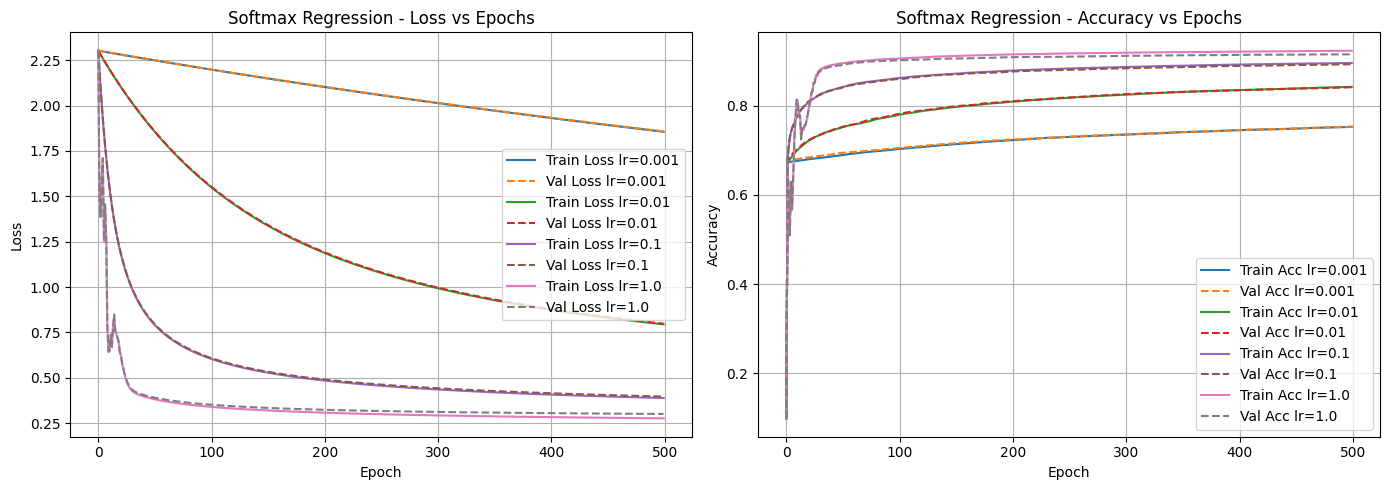

In [32]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
for lr in learning_rates:
    plt.plot(histories[lr]['train_loss'], label=f"Train Loss lr={lr}")
    plt.plot(histories[lr]['val_loss'], '--', label=f"Val Loss lr={lr}")
plt.title("Softmax Regression - Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
for lr in learning_rates:
    plt.plot(histories[lr]['train_acc'], label=f"Train Acc lr={lr}")
    plt.plot(histories[lr]['val_acc'], '--', label=f"Val Acc lr={lr}")
plt.title("Softmax Regression - Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### neural network

In [34]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
model_histories = {}

for lr in learning_rates:
    print(f"\nTraining PyTorch Model with learning rate = {lr}")
    # Initialize a fresh model for each learning rate
    model = FeedforwardNN(input_size=784, hidden1=256, hidden2=128, output_size=10)
    trained_model, history = train_model(
        model,
        train_dataset_flat, val_dataset_flat, test_dataset_flat,
        batch_size=64,
        lr=lr,
        num_epochs=20,  
        patience=5
    )
    model_histories[lr] = history



Training PyTorch Model with learning rate = 0.001
Using device: cuda
Epoch [1/20] Train Loss: 2.1427, Train Acc: 34.04% | Val Loss: 1.9433, Val Acc: 53.91%
Epoch [2/20] Train Loss: 1.7486, Train Acc: 62.36% | Val Loss: 1.5516, Val Acc: 68.65%
Epoch [3/20] Train Loss: 1.3695, Train Acc: 72.32% | Val Loss: 1.2023, Val Acc: 75.42%
Epoch [4/20] Train Loss: 1.0658, Train Acc: 77.87% | Val Loss: 0.9506, Val Acc: 79.94%
Epoch [5/20] Train Loss: 0.8608, Train Acc: 81.24% | Val Loss: 0.7883, Val Acc: 82.19%
Epoch [6/20] Train Loss: 0.7288, Train Acc: 83.32% | Val Loss: 0.6827, Val Acc: 83.90%
Epoch [7/20] Train Loss: 0.6408, Train Acc: 84.79% | Val Loss: 0.6111, Val Acc: 85.18%
Epoch [8/20] Train Loss: 0.5794, Train Acc: 85.82% | Val Loss: 0.5597, Val Acc: 86.14%
Epoch [9/20] Train Loss: 0.5343, Train Acc: 86.54% | Val Loss: 0.5209, Val Acc: 86.84%
Epoch [10/20] Train Loss: 0.4991, Train Acc: 87.28% | Val Loss: 0.4908, Val Acc: 87.46%
Epoch [11/20] Train Loss: 0.4716, Train Acc: 87.81% | Val L

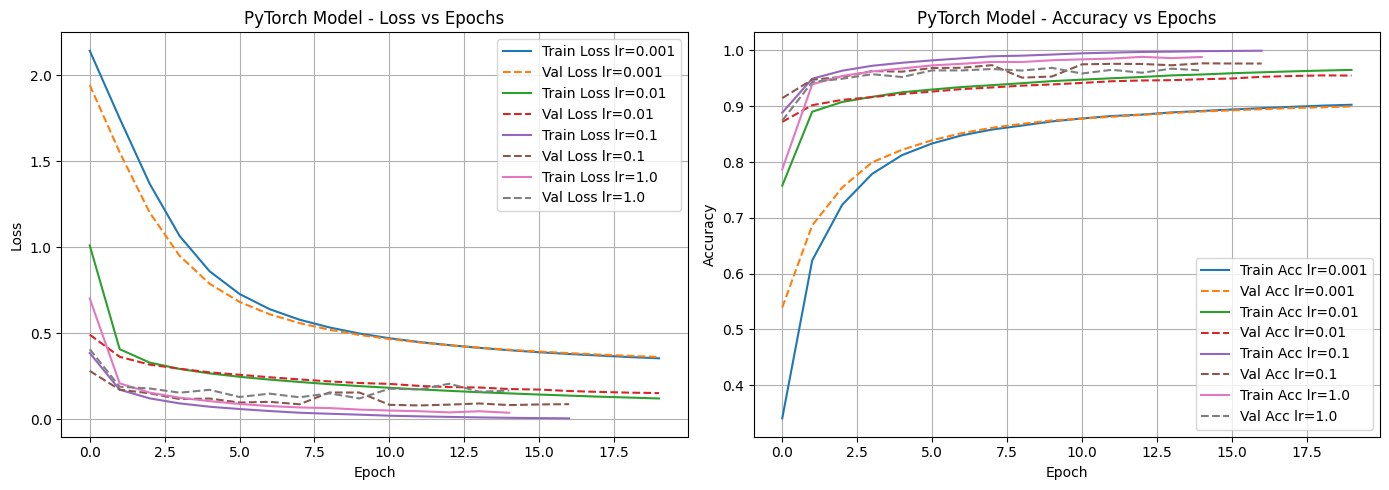

In [35]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
for lr in learning_rates:
    plt.plot(model_histories[lr]['train_loss'], label=f"Train Loss lr={lr}")
    plt.plot(model_histories[lr]['val_loss'], '--', label=f"Val Loss lr={lr}")
plt.title("PyTorch Model - Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
for lr in learning_rates:
    plt.plot(model_histories[lr]['train_acc'], label=f"Train Acc lr={lr}")
    plt.plot(model_histories[lr]['val_acc'], '--', label=f"Val Acc lr={lr}")
plt.title("PyTorch Model - Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Batch Size analysis

In [44]:
batch_sizes = [16, 32, 64, 128]
model_histories = {}

for bs in batch_sizes:
    print(f"\nTraining PyTorch model with batch size = {bs}")
    
    # Initialize a fresh model each time
    model = FeedforwardNN(input_size=784, hidden1=256, hidden2=128, output_size=10)  # Replace with your actual model class
    trained_model, history = train_model(
        model,
        train_dataset_flat,
        val_dataset_flat,
        test_dataset_flat,
        batch_size=bs,
        lr=0.01,           # keep learning rate constant for now
        num_epochs=20,     # adjust epochs as needed
        patience=5
    )
    
    model_histories[bs] = history



Training PyTorch model with batch size = 16
Using device: cuda
Epoch [1/20] Train Loss: 0.5049, Train Acc: 86.46% | Val Loss: 0.2970, Val Acc: 91.30%
Epoch [2/20] Train Loss: 0.2492, Train Acc: 92.81% | Val Loss: 0.2314, Val Acc: 93.25%
Epoch [3/20] Train Loss: 0.1955, Train Acc: 94.37% | Val Loss: 0.2023, Val Acc: 94.09%
Epoch [4/20] Train Loss: 0.1608, Train Acc: 95.33% | Val Loss: 0.1694, Val Acc: 95.08%
Epoch [5/20] Train Loss: 0.1364, Train Acc: 96.04% | Val Loss: 0.1545, Val Acc: 95.38%
Epoch [6/20] Train Loss: 0.1169, Train Acc: 96.62% | Val Loss: 0.1419, Val Acc: 95.95%
Epoch [7/20] Train Loss: 0.1023, Train Acc: 97.06% | Val Loss: 0.1301, Val Acc: 96.16%
Epoch [8/20] Train Loss: 0.0900, Train Acc: 97.43% | Val Loss: 0.1197, Val Acc: 96.55%
Epoch [9/20] Train Loss: 0.0795, Train Acc: 97.74% | Val Loss: 0.1124, Val Acc: 96.66%
Epoch [10/20] Train Loss: 0.0709, Train Acc: 98.00% | Val Loss: 0.1075, Val Acc: 96.79%
Epoch [11/20] Train Loss: 0.0634, Train Acc: 98.20% | Val Loss: 0

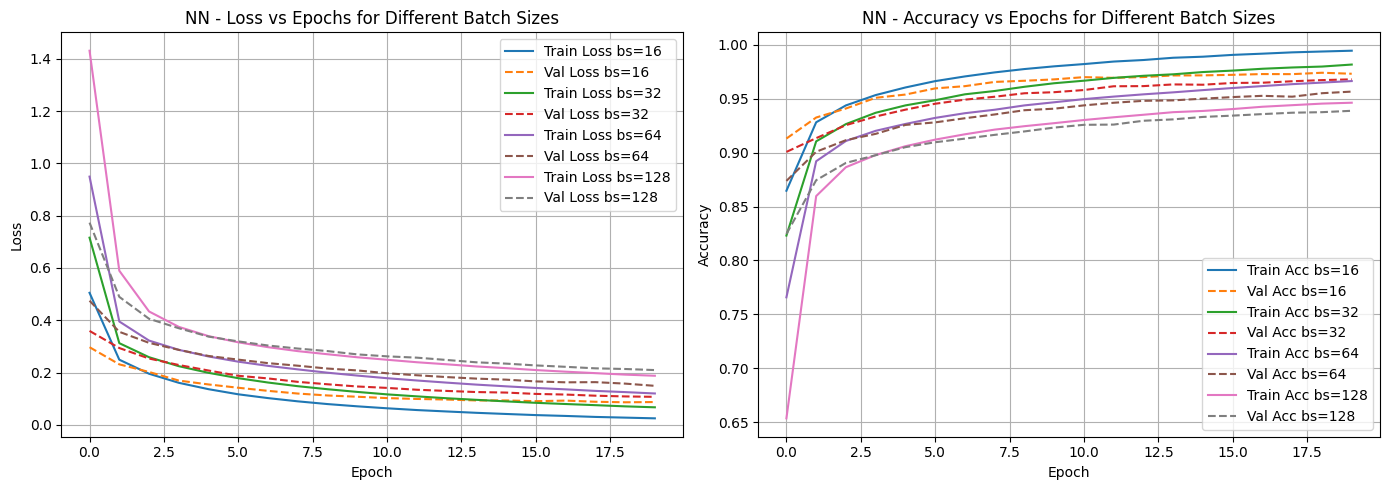

In [45]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
for bs in batch_sizes:
    plt.plot(model_histories[bs]['train_loss'], label=f"Train Loss bs={bs}")
    plt.plot(model_histories[bs]['val_loss'], '--', label=f"Val Loss bs={bs}")
plt.title("NN - Loss vs Epochs for Different Batch Sizes")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
for bs in batch_sizes:
    plt.plot(model_histories[bs]['train_acc'], label=f"Train Acc bs={bs}")
    plt.plot(model_histories[bs]['val_acc'], '--', label=f"Val Acc bs={bs}")
plt.title("NN - Accuracy vs Epochs for Different Batch Sizes")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Batch Size Analysis Conclusion

Small Batch Sizes (16, 32):

Gradient Noise: High ,the gradients are noisy because each update is based on fewer examples.

Convergence Speed: Slower per epoch since updates are less stable.

Final Performance: Often slightly better generalization on validation data because the noise helps escape sharp minima.

Training Time: Longer overall, because more updates are required per epoch.

Medium Batch Sizes (64):

Gradient Noise: Moderate, a balance between stability and noise.

Convergence Speed: Faster than small batches and still retains decent generalization.

Final Performance: Typically good, stable and efficient training.

Training Time: Reasonable, fewer updates per epoch than smaller batches.

Large Batch Sizes (128 or higher):

Gradient Noise: Low, gradients are stable and smooth.

Convergence Speed: Faster per epoch since each update uses more data.

Final Performance: Sometimes slightly worse generalization, can overfit if learning rate isn’t adjusted.

Training Time: Faster per epoch but each epoch processes more samples; overall wall-clock time may be similar depending on hardware.

## Architecture analysis

In [46]:

class FlexibleNN(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_neurons, output_size):
        """
        input_size: int, number of input features
        hidden_layers: int, number of hidden layers
        hidden_neurons: int, neurons per hidden layer
        output_size: int, number of output classes
        """
        super(FlexibleNN, self).__init__()
        layers = []
        in_features = input_size
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_neurons))
            layers.append(nn.ReLU())
            in_features = hidden_neurons
        
        layers.append(nn.Linear(in_features, output_size))  # Output layer
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [48]:
hidden_layers_list = [2, 3, 4, 5]
neurons_list = [64, 128, 256, 512]

results = []

input_size = X_train_tensor.shape[1]  # number of features
output_size = 10                       # number of classes

for layers in hidden_layers_list:
    for neurons in neurons_list:
        print(f"\nTraining NN with {layers} hidden layers, {neurons} neurons per layer")
        model = FlexibleNN(input_size, layers, neurons, output_size)
        
        _, history = train_model(
            model,
            train_dataset_flat,
            val_dataset_flat,
            test_dataset_flat,
            batch_size=64,
            lr=0.01,
            num_epochs=10,
            patience=5
        )
        
        final_train_acc = history['train_acc'][-1]
        final_val_acc = history['val_acc'][-1]
        final_train_loss = history['train_loss'][-1]
        final_val_loss = history['val_loss'][-1]
        
        results.append({
            "Layers": layers,
            "Neurons": neurons,
            "Train Loss": final_train_loss,
            "Val Loss": final_val_loss,
            "Train Acc": final_train_acc,
            "Val Acc": final_val_acc
        })



Training NN with 2 hidden layers, 64 neurons per layer
Using device: cuda
Epoch [1/10] Train Loss: 2.0434, Train Acc: 42.91% | Val Loss: 1.4572, Val Acc: 70.00%
Epoch [2/10] Train Loss: 0.8754, Train Acc: 79.07% | Val Loss: 0.5909, Val Acc: 83.97%
Epoch [3/10] Train Loss: 0.4974, Train Acc: 86.36% | Val Loss: 0.4386, Val Acc: 88.23%
Epoch [4/10] Train Loss: 0.4001, Train Acc: 88.81% | Val Loss: 0.3818, Val Acc: 89.52%
Epoch [5/10] Train Loss: 0.3553, Train Acc: 90.02% | Val Loss: 0.3502, Val Acc: 90.04%
Epoch [6/10] Train Loss: 0.3290, Train Acc: 90.66% | Val Loss: 0.3354, Val Acc: 90.30%
Epoch [7/10] Train Loss: 0.3097, Train Acc: 91.21% | Val Loss: 0.3166, Val Acc: 90.79%
Epoch [8/10] Train Loss: 0.2943, Train Acc: 91.62% | Val Loss: 0.3079, Val Acc: 91.12%
Epoch [9/10] Train Loss: 0.2803, Train Acc: 92.04% | Val Loss: 0.2930, Val Acc: 91.39%
Epoch [10/10] Train Loss: 0.2676, Train Acc: 92.37% | Val Loss: 0.2801, Val Acc: 91.81%

Training NN with 2 hidden layers, 128 neurons per lay

In [49]:

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["Val Acc"], ascending=False)
print(df_results)


    Layers  Neurons  Train Loss  Val Loss  Train Acc   Val Acc
7        3      512    0.236723  0.245950   0.933100  0.928272
3        2      512    0.246929  0.257679   0.929509  0.926560
6        3      256    0.255398  0.266476   0.927654  0.923778
1        2      128    0.262980  0.274805   0.925918  0.921138
15       5      512    0.298117  0.284749   0.915192  0.920924
2        2      256    0.259937  0.282181   0.926774  0.919425
0        2       64    0.267596  0.280115   0.923659  0.918141
9        4      128    0.267867  0.281093   0.923207  0.917214
4        3       64    0.272315  0.288871   0.922303  0.916976
10       4      256    0.253957  0.283144   0.926441  0.915168
11       4      512    0.240730  0.287425   0.930960  0.913575
5        3      128    0.275164  0.299562   0.921328  0.913076
8        4       64    0.305468  0.312377   0.914907  0.913052
14       5      256    0.362232  0.347826   0.896761  0.900495
13       5      128    0.386154  0.420546   0.890768  0

### Observations

Best Validation Accuracy:

The highest Val Acc is 0.9283 with 3 hidden layers and 512 neurons per layer.

Close second is 2 layers, 512 neurons (Val Acc ≈ 0.9266).

Indicates that moderately deep networks with large layers perform best.

Effect of Number of Layers:

Increasing layers beyond 3 does not always improve performance.

4-5 layers sometimes show slightly lower validation accuracy, probably due to overfitting or difficulty in optimization.

Effect of Neurons per Layer:

Larger neurons per layer generally improve accuracy.

Small layers (64 neurons) perform worse across all depths.

Example: 2 layers × 64 neurons → Val Acc ≈ 0.9181, much lower than 2×512 (Val Acc ≈ 0.9266).

Train vs Validation Loss:

For very large networks (5 layers × 512 neurons), train loss is low but validation loss slightly higher so possible overfitting.

Very small networks (2×64) have higher train and val loss → underfitting.

Sweet Spot:

3 hidden layers × 512 neurons balances capacity and generalization.

Increasing neurons beyond 512 or layers beyond 3 does not give significant gain and may slow training.

## evaluatinf best model

In [54]:
def evaluate_model(model, test_dataset, batch_size=32, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.view(inputs.size(0), -1)  # 🔥 flatten
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # Accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n✅ Final Test Accuracy: {accuracy*100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Misclassified examples
    misclassified_idx = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]
    print(f"\nNumber of misclassified examples: {len(misclassified_idx)}")

    return all_preds, all_labels, misclassified_idx


Using device: cuda
Epoch [1/1000] Train Loss: 0.0412, Train Acc: 98.91% | Val Loss: 0.1217, Val Acc: 96.59%
Epoch [2/1000] Train Loss: 0.0367, Train Acc: 99.08% | Val Loss: 0.2776, Val Acc: 92.66%
Epoch [3/1000] Train Loss: 0.0332, Train Acc: 99.13% | Val Loss: 0.1304, Val Acc: 96.49%
Epoch [4/1000] Train Loss: 0.0300, Train Acc: 99.28% | Val Loss: 0.1274, Val Acc: 96.78%
Epoch [5/1000] Train Loss: 0.0251, Train Acc: 99.38% | Val Loss: 0.1472, Val Acc: 96.09%
Epoch [6/1000] Train Loss: 0.0235, Train Acc: 99.41% | Val Loss: 0.1356, Val Acc: 96.62%
Early stopping triggered.

✅ Final Test Accuracy: 98.37%


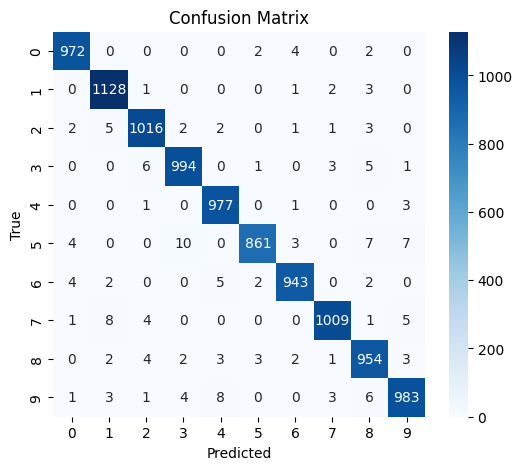


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Number of misclassified examples: 163


In [56]:
# Define best model  3 hidden layers × 512 neurons
best_model = FlexibleNN(input_size=784, hidden_layers=3, hidden_neurons=512, output_size=10)
best_model, history = train_model(
            model,
            train_dataset_flat,
            val_dataset_flat,
            test_dataset_flat,
            batch_size=64,
            lr=0.01,
            num_epochs=1000, # 3ashan keda keda fee early stop
            patience=5
        )

# Evaluate on test set
preds, labels, misclassified = evaluate_model(best_model, test_dataset, batch_size=64)



In [60]:
def show_misclassified(model, test_loader, classes, device, num_images=10):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.view(images.size(0), -1))  # flatten for forward
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified_images.append(images[i].cpu())
                    misclassified_labels.append(labels[i].cpu())
                    misclassified_preds.append(preds[i].cpu())

    # plot some misclassified
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = misclassified_images[i].view(28, 28)  # reshape back to 28x28
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"T:{classes[misclassified_labels[i]]}\nP:{classes[misclassified_preds[i]]}")
        axes[i].axis("off")

    plt.show()


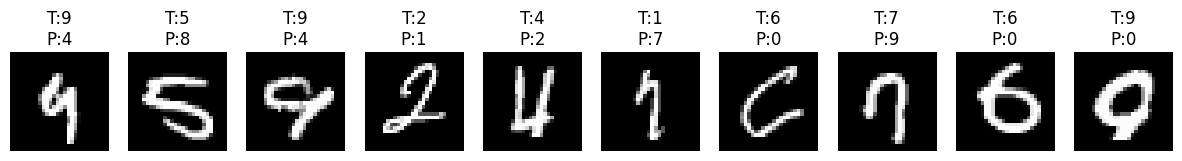

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = [str(i) for i in range(10)]  # if MNIST, classes are digits 0-9
show_misclassified(best_model, test_loader, classes, device, num_images=10)


# Bonus

## making cnn

In [69]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolution layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(2, 2)  # reduces to 14x14
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # conv1 + ReLU
        x = F.relu(self.conv2(x))   # conv2 + ReLU
        x = self.pool(x)            # max pool
        x = self.dropout(x)
        x = x.view(x.size(0), -1)   # flatten
        x = F.relu(self.fc1(x))     # dense layer
        x = self.dropout(x)
        x = self.fc2(x)             # output logits
        return x


In [72]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        images = images.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(train_loader), correct / total
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 1, 28, 28)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(test_loader), correct / total


In [73]:
# Pick which model to train
model = SimpleCNN().to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/20 | Train Loss: 0.2080, Train Acc: 0.9350 | Val Loss: 0.0708, Val Acc: 0.9789
Epoch 2/20 | Train Loss: 0.0707, Train Acc: 0.9781 | Val Loss: 0.0538, Val Acc: 0.9836
Epoch 3/20 | Train Loss: 0.0464, Train Acc: 0.9857 | Val Loss: 0.0494, Val Acc: 0.9854
Epoch 4/20 | Train Loss: 0.0388, Train Acc: 0.9875 | Val Loss: 0.0414, Val Acc: 0.9883
Epoch 5/20 | Train Loss: 0.0296, Train Acc: 0.9908 | Val Loss: 0.0419, Val Acc: 0.9888
Epoch 6/20 | Train Loss: 0.0256, Train Acc: 0.9913 | Val Loss: 0.0476, Val Acc: 0.9869
Epoch 7/20 | Train Loss: 0.0232, Train Acc: 0.9919 | Val Loss: 0.0496, Val Acc: 0.9871
Epoch 8/20 | Train Loss: 0.0189, Train Acc: 0.9935 | Val Loss: 0.0439, Val Acc: 0.9884
Epoch 9/20 | Train Loss: 0.0156, Train Acc: 0.9948 | Val Loss: 0.0478, Val Acc: 0.9894
Epoch 10/20 | Train Loss: 0.0156, Train Acc: 0.9946 | Val Loss: 0.0466, Val Acc: 0.9899
Epoch 11/20 | Train Loss: 0.0148, Train Acc: 0.9948 | Val Loss: 0.0459, Val Acc: 0.9899
Epoch 12/20 | Train Loss: 0.0126, Train A

The Convolutional Neural Network (CNN) achieved an accuracy of 99.03%, surpassing the fully connected network. This improvement highlights the benefit of spatial feature learning, as CNNs effectively capture local patterns such as edges and textures in images. Unlike fully connected networks, which treat input pixels independently, CNNs exploit spatial hierarchies, leading to more robust and efficient learning. This demonstrates the clear advantage of CNNs in image classification tasks like MNIST.


In [78]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5, use_batchnorm=False):
        super(CNN, self).__init__()
        
        layers = []
        layers.append(nn.Conv2d(1, 32, kernel_size=3, padding=1))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2, 2))
        layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2, 2))
        layers.append(nn.Dropout(dropout_rate))
        
        self.conv = nn.Sequential(*layers)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout_fc = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# Run Experiments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

dropout_rates = [0.1, 0.3, 0.5, 0.7]
use_batchnorm_options = [False, True]

results = []

for bn in use_batchnorm_options:
    for dr in dropout_rates:
        print(f"\nTraining model with Dropout={dr}, BatchNorm={bn}")
        model = CNN(dropout_rate=dr, use_batchnorm=bn).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        for epoch in range(1, 6):  # train for 5 epochs
            train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
            test_loss, test_acc = evaluate(model, test_loader, criterion, device)
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

        results.append((dr, bn, test_acc))

print("\nFinal Results:")
for dr, bn, acc in results:
    print(f"Dropout={dr}, BatchNorm={bn} -> Accuracy={acc:.4f}")



Training model with Dropout=0.1, BatchNorm=False
Epoch 1: Train Loss=0.2250, Test Loss=0.0599, Test Acc=0.9813
Epoch 2: Train Loss=0.0645, Test Loss=0.0358, Test Acc=0.9878
Epoch 3: Train Loss=0.0458, Test Loss=0.0316, Test Acc=0.9897
Epoch 4: Train Loss=0.0371, Test Loss=0.0283, Test Acc=0.9909
Epoch 5: Train Loss=0.0308, Test Loss=0.0287, Test Acc=0.9899

Training model with Dropout=0.3, BatchNorm=False
Epoch 1: Train Loss=0.2848, Test Loss=0.0616, Test Acc=0.9807
Epoch 2: Train Loss=0.0937, Test Loss=0.0361, Test Acc=0.9884
Epoch 3: Train Loss=0.0722, Test Loss=0.0306, Test Acc=0.9889
Epoch 4: Train Loss=0.0599, Test Loss=0.0273, Test Acc=0.9906
Epoch 5: Train Loss=0.0550, Test Loss=0.0266, Test Acc=0.9920

Training model with Dropout=0.5, BatchNorm=False
Epoch 1: Train Loss=0.4025, Test Loss=0.0720, Test Acc=0.9760
Epoch 2: Train Loss=0.1643, Test Loss=0.0534, Test Acc=0.9830
Epoch 3: Train Loss=0.1327, Test Loss=0.0405, Test Acc=0.9877
Epoch 4: Train Loss=0.1157, Test Loss=0.0362